#### 0. Import basic methods from source.py
Import useful methods from source.py (NB: can later be integrated into a package)

In [1]:
from source import *

#### 1. Open xls file and ingest Inputs table
Note I am assuming that all inputs will be aggregated into one single inputs table

In [2]:
filename = r'Input data python file.xlsx'

In [3]:
# load workbook
wb = load_workbook(filename)

In [4]:
# load worksheet
ws = wb["Python test sheet"]

In [5]:
mapping = {}

for entry, data_boundary in ws.tables.items():
    # parse the data within the ref boundary
    data = ws[data_boundary]
    # extract the data 
    # the inner list comprehension gets the values for each cell in the table
    content = [[cell.value for cell in ent] 
               for ent in data
          ]
    
    # find header
    header = content[0]
    
    # find the rest ... the contents, excluding the header
    rest = content[1:]
    
    # create dataframe with the column names
    # and pair table name with dataframe
    df = pd.DataFrame(rest, columns = header)
    mapping[entry] = df

In [6]:
Inputs = pd.DataFrame(mapping['Inputs'])
Inputs.head()

,Category,Sub-system,Element,Component,Description,Number,Unit
0,Capex,Wind energy source & Transport,Offshore wind park,Foundations,Jacket or monopile costs (Development and Proj...,100000.0,USD per unit
1,Capex,Wind energy source & Transport,Offshore wind park,Foundations,Jacket or monopile costs (Procurement),400000.0,USD per unit
2,Capex,Wind energy source & Transport,Offshore wind park,Foundations,Jacket or monopile costs (Installation and Com...,300000.0,USD per unit
3,Capex,Wind energy source & Transport,Offshore wind park,Foundations,Corrosion protection costs (Development and Pr...,50000.0,USD per unit
4,Capex,Wind energy source & Transport,Offshore wind park,Foundations,Corrosion protection costs (Procurement),90000.0,USD per unit


#### 2. Select one item from the Inputs table (generate cashflow overview)
* Sub-system
* Element
* Component
* Description
* Number
* Unit

##### A. do per item

CPU times: total: 0 ns
Wall time: 0 ns


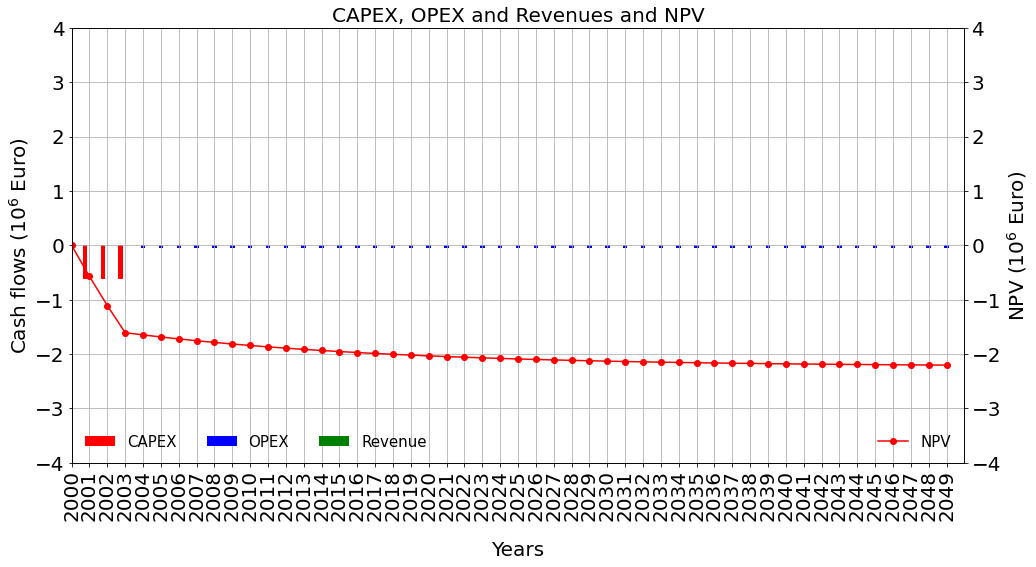

In [14]:
%time
df_Foundations = Inputs_2_cashflow(Inputs, 
                                   startyear=2000,
                                   lifecycle=11,
                                   subsystem='Wind energy source & Transport',
                                   element='Offshore wind park',
                                   component='Foundations',
                                   Debug=False)
df_npv_Foundations = calculate_npv(df_Foundations)
lims = [-4,4]
create_npv_plot(df_npv_Foundations, cash_flow_lims=lims, npv_lims=lims)

CPU times: total: 0 ns
Wall time: 0 ns


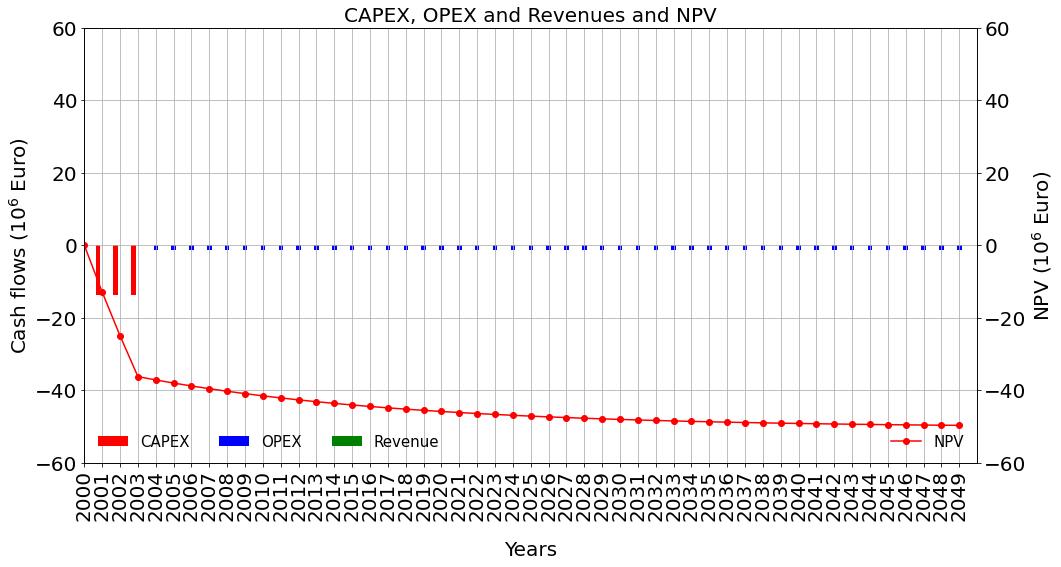

In [15]:
%time
df_Turbines = Inputs_2_cashflow(Inputs, 
                                   startyear=2000,
                                   lifecycle=11,
                                   subsystem='Wind energy source & Transport',
                                   element='Offshore wind park',
                                   component='Turbines',
                                   Debug=False)
df_npv_Turbines = calculate_npv(df_Turbines)
lims = [-60,60]
create_npv_plot(df_npv_Turbines, cash_flow_lims=lims, npv_lims=lims)

##### B. combine two items

In [9]:
df_Foundations = Inputs_2_cashflow(Inputs, startyear=2022, lifecycle=11, component='Foundations',Debug=False)
df_Turbines = Inputs_2_cashflow(Inputs, startyear=2028, lifecycle=11, component='Turbines',Debug=False)
df_combined = combine_cashflow_dataframes([df_Foundations, df_Turbines])

In [10]:
df_npv_combined = calculate_npv(df_combined)

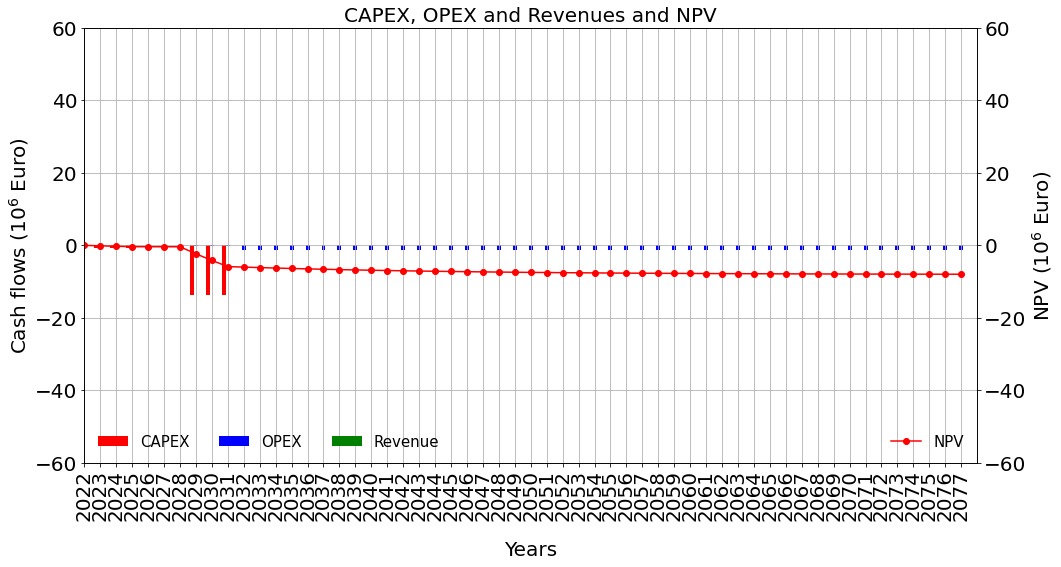

In [16]:
lims=[-60,60]
create_npv_plot(df_npv_combined, cash_flow_lims=lims, npv_lims=lims)